<a href="https://colab.research.google.com/github/acedesci/scanalytics/blob/master/S06_Descriptive_Analytics/S06_LectureEx_Data_Analytics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# S6 - Descriptive Data Modeling
Programming topics covered in this section:
* Data transformation for descriptive analytics
* Clustering and segmentation models

Examples include:
* Transportation shipment data analytics

In [1]:
import pandas as pd

## 1. Importing data and creating a report
In this exercise, we will explore some adapted data set which provides supply chain health commodity shipment and pricing data. Specifically, the data set identifies Antiretroviral (ARV) and HIV lab shipments to supported countries. In addition, the data set provides the commodity pricing and associated supply chain expenses necessary to move the commodities to countries for use. The original data are provided by the US Agency for International Development and can be accessed at [this page](https://catalog.data.gov/dataset/supply-chain-shipment-pricing-data).

This is a description of our adapted data in the file `SCMS_Delivery_History_Dataset.csv`.

| VARIABLE NAME | DESCRIPTION | 
|:----|:----|
|id| identification number|
|project code|identification of the project|
|country|country to which the items are shipped|
|vendor|identification of the vendor of the item|
|manufacturing site|name of the manufacturer of the item|
|shipment mode|transportation mode (e.g., air, truck)|
|scheduled delivery date|programmed date for delivery|
|delivered to client date|real date of delivery|
|delivery recorded date|registered date of delivery|
|product group|main category of the item|
|product subgroup|subcategory of the item (e.g., HIV test, pediatric, Adult) |
|molecule type|description of the composition of the item (e.g., Nevirapine, HIV 1/2, Didanosine)|
|brand| item brand (e.g, generic or any other commercial brand)|
|dosage| specifications about the dosage of each item (e.g.,10mg/ml, 200mg)|
|dosage form|instructions for consumption (e.g., capsule, tablet, oral solution) |
|units per pack| number of units in each package|
|quantity pack sold| number of packages shipped to the specified country|
|value sold| total value in $\$$ USD of the shipment (i.e., pack_price * quantity pack sold|
|pack price| price in $\$$ USD per package|
|unit price| price in $\$$ USD per unit|
|weight (kilograms)| total weight in kilograms of the shipment|
|freight cost (usd)| value in $\$$USD paid for transportation|
|insurance (usd)|value in $\$$USD paid for insurance|



Let's import our data.

In [104]:
url = 'https://raw.githubusercontent.com/acedesci/scanalytics/master/S05_Data_Preprocessing/Supply_Chain_Shipment_Pricing_Data.csv'
df_SC = pd.read_csv(url)  # reading data file into a DataFrame

df_SC.columns = df_SC.columns.str.replace(' ', '_')
df_SC.columns = df_SC.columns.str.replace('(', '')
df_SC.columns = df_SC.columns.str.replace(')', '')
df_SC.columns = df_SC.columns.str.replace('#', '')
df_SC.columns = df_SC.columns.str.replace('/', '')

df_SC['pq_first_sent_to_client_date'] = pd.to_datetime(df_SC['pq_first_sent_to_client_date'], errors='coerce')
df_SC['scheduled_delivery_date'] = pd.to_datetime(df_SC['scheduled_delivery_date'], errors='coerce')
df_SC['delivered_to_client_date'] = pd.to_datetime(df_SC['delivered_to_client_date'], errors='coerce')
df_SC['weight_kilograms'] = pd.to_numeric(df_SC['weight_kilograms'], errors='coerce')
df_SC['freight_cost_usd'] = pd.to_numeric(df_SC['freight_cost_usd'], errors='coerce')

df_SC = df_SC[(df_SC['freight_cost_usd'].notna()) & df_SC['weight_kilograms'] & (df_SC['delivered_to_client_date'] >= '2010-01-01')]

selected_columns = ['country', 'line_item_value','weight_kilograms','freight_cost_usd']
print(df_SC.isna().sum())

df_SC_selected = df_SC[selected_columns].groupby(['country']).agg({'line_item_value':'sum','weight_kilograms':'mean','freight_cost_usd':'mean'})
for col in df_SC_selected.columns:
    df_SC_selected['z_'+col] = (df_SC_selected[col] - df_SC_selected[col].mean())/df_SC_selected[col].std()

normal_columns = list(df_SC_selected.columns[:3])
z_columns = list(df_SC_selected.columns[3:])


id                                0
project_code                      0
pq_                               0
po__so_                           0
asndn_                            0
country                           0
managed_by                        0
fulfill_via                       0
vendor_inco_term                  0
shipment_mode                     0
pq_first_sent_to_client_date      5
po_sent_to_vendor_date            0
scheduled_delivery_date           0
delivered_to_client_date          0
delivery_recorded_date            0
product_group                     0
sub_classification                0
vendor                            0
item_description                  0
moleculetest_type                 0
brand                             0
dosage                          906
dosage_form                       0
unit_of_measure_per_pack          0
line_item_quantity                0
line_item_value                   0
pack_price                        0
unit_price                  

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:1969: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


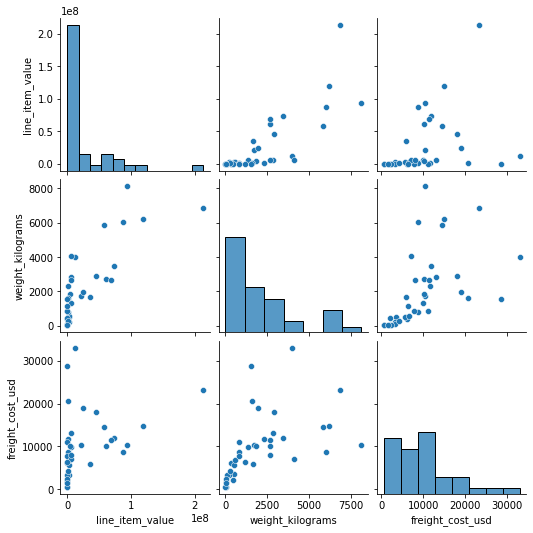

In [110]:
import seaborn as sns
sns.pairplot(data=df_SC_selected[normal_columns], size=2.5, palette = 'deep')

In [119]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, AgglomerativeClustering

# K-Mean clustering
X = df_SC_selected[z_columns].values
kmeans = KMeans(n_clusters=3, random_state=0).fit(X)
df_SC_selected['K3_cluster'] = kmeans.labels_



,line_item_value,weight_kilograms,freight_cost_usd,z_line_item_value,z_weight_kilograms,z_freight_cost_usd,K3_cluster,A2_cluster,A3_cluster,A4_cluster
country,,,,,,,,,,
Afghanistan,1.736000e+03,44.500000,540.525000,-0.561087,-0.957141,-1.250145,1,0,2,2
Angola,1.816000e+05,362.200000,6166.414000,-0.557071,-0.808260,-0.499620,1,0,2,2
Benin,5.454805e+05,2323.600000,11638.258000,-0.548946,0.110891,0.230354,1,0,0,1
Botswana,1.303711e+06,525.766667,3451.025333,-0.532016,-0.731610,-0.861868,1,0,2,2
Burundi,2.277174e+06,512.750000,5572.184286,-0.510279,-0.737710,-0.578894,1,0,2,2
Cameroon,1.234366e+07,3977.666667,33026.949815,-0.285504,0.886021,3.083723,2,0,0,3
"Congo, DRC",2.777920e+06,592.355769,6721.951058,-0.499098,-0.700405,-0.425509,1,0,2,2
Côte d'Ivoire,6.147014e+07,2699.873118,10091.968387,0.811442,0.287221,0.024070,2,0,0,1
Dominican Republic,1.558134e+06,824.892857,8780.877857,-0.526335,-0.591433,-0.150836,1,0,2,2


/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:1969: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


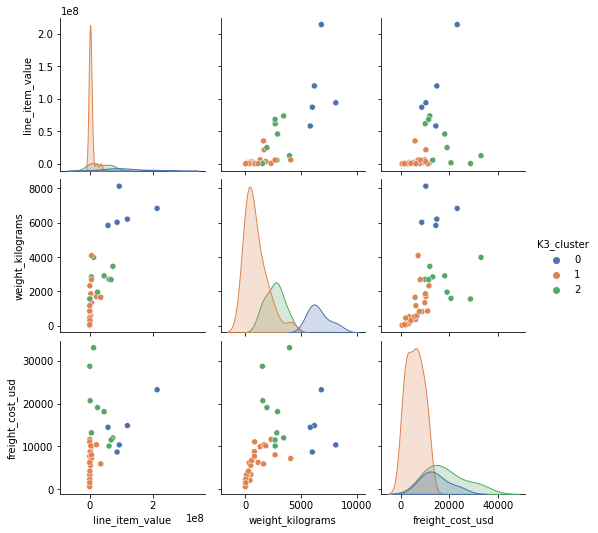

In [108]:
import seaborn as sns

sns.pairplot(data=df_SC_selected[normal_columns+["K3_cluster"]], hue='K3_cluster', size=2.5, palette = 'deep')


In [ ]:

# Hierarchical clustering
hcluster2 = AgglomerativeClustering(n_clusters=2).fit(X)
df_SC_selected['A2_cluster'] = hcluster2.labels_

hcluster3 = AgglomerativeClustering(n_clusters=3).fit(X)
df_SC_selected['A3_cluster'] = hcluster3.labels_

hcluster4 = AgglomerativeClustering(n_clusters=4).fit(X)
df_SC_selected['A4_cluster'] = hcluster4.labels_

df_SC_selected.tail()

Text(0.5, 1.0, 'A4_cluster')

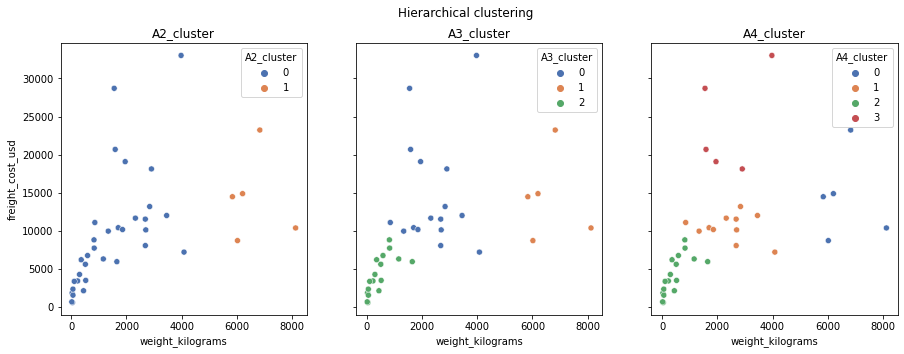

In [125]:
from matplotlib import pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(15, 5),sharey=True)
fig.suptitle('Hierarchical clustering')

# 2 clusters
sns.scatterplot(data = df_SC_selected, ax=axes[0], x=normal_columns[1], y=normal_columns[2], hue='A2_cluster', palette = 'deep')
axes[0].set_title('A2_cluster')

# 3 clusters
sns.scatterplot(data = df_SC_selected, ax=axes[1], x=normal_columns[1], y=normal_columns[2], hue='A3_cluster', palette = 'deep')
axes[1].set_title('A3_cluster')

# 4 clusters
sns.scatterplot(data = df_SC_selected, ax=axes[2], x=normal_columns[1], y=normal_columns[2], hue='A4_cluster', palette = 'deep')
axes[2].set_title('A4_cluster')